<a href="https://colab.research.google.com/github/m-aliabbas/EvolutionaryComputing/blob/master/Resnet34ThesisFinal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from zipfile import ZipFile 
def unZip(file_name):
  with ZipFile(file_name, 'r') as zip: 
      zip.extractall() 
      print('Done!') 

In [0]:
file_name = '/content/drive/chestXRay.zip'

In [0]:
path="/content/drive/My Drive/"
file_name=path+'chestXRay.zip'

In [5]:
unZip(file_name)

Done!


In [6]:
unZip('chest_xray.zip')

Done!


In [0]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesPos= sorted(glob.glob('chest_xray/train/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/val/NORMAL/*.jpeg'))
filesPos+=sorted(glob.glob('chest_xray/test/NORMAL/*.jpeg'))



In [0]:
filesNeg=sorted(glob.glob('chest_xray/train/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/val/PNEUMONIA/*.jpeg'))
filesNeg+=sorted(glob.glob('chest_xray/test/PNEUMONIA/*.jpeg'))

In [9]:
random.shuffle(filesNeg)
len(filesPos),len(filesNeg)

(1583, 4273)

In [0]:
filesNeg=filesNeg[:2100]

In [0]:
pos_labels=[[i,0] for i in filesPos]
neg_labels=[[i,1] for i in filesNeg]
ds=pos_labels+neg_labels

In [0]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [0]:
from sklearn.model_selection import train_test_split
dfTrain,dfTest=train_test_split(df, shuffle=False,test_size=0.1, random_state=42)

In [14]:
len(dfTrain),len(dfTest)

(3314, 369)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff40edd7b70>]], dtype=object)

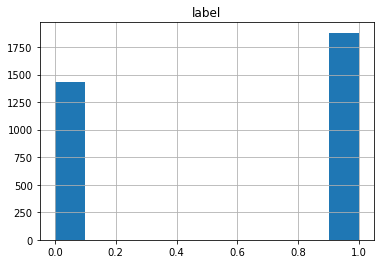

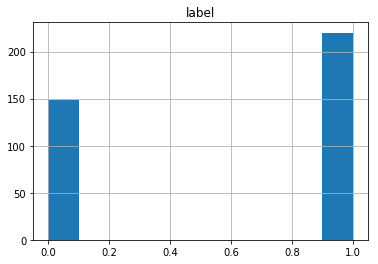

In [15]:
dfTrain.hist('label')
dfTest.hist('label')

In [0]:
bs =16
sz=224
tfms = get_transforms(do_flip=True,flip_vert=True,max_lighting=0.4,max_zoom=1.1)
src = (ImageList.from_df(df=dfTrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

In [17]:
data.classes

[0, 1]

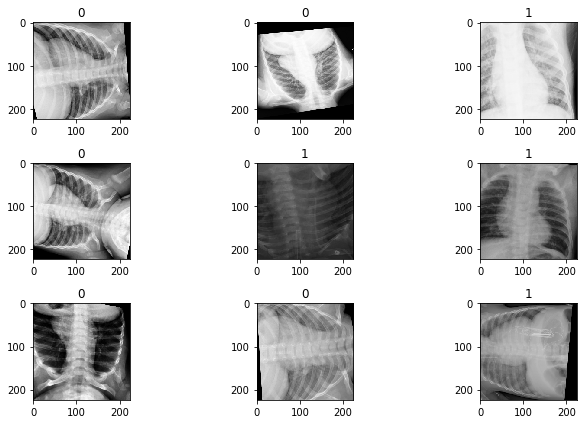

In [18]:
data.show_batch(rows=3, figsize=(10,6), hide_axis=False)

In [0]:
from sklearn.metrics import roc_auc_score,f1_score
def f1_score_a(y_pred,y_true,tens=True):
#     score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    f1a_score=f1_score(y_true, np.round(torch.sigmoid(y_pred)[:,1]), average='macro') 
    if tens:
#         score=tensor(score)
        f1a_score=tensor(f1a_score)
    else:
        f1a_score=f1a_score
    return f1a_score
# from sklearn.metrics import f1_score
# def f1_out(y_ture,y_pred,tens=True):
#     f1a_score=f1_score(y_true, torch.sigmoid(y_pred)[:,1], average='macro') 
#     if tens:
#         f1a_score=tensor(f1a_score)
#     else:
#         f1a_score=f1a_score
#     return f1a_score

In [0]:

import torch 
import torchvision
model = torchvision.models.resnet34(pretrained=True)

In [0]:
num_ftrs = model.fc.in_features
model.fc=nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 128),
    nn.Dropout(0.3),
    nn.Linear(128, 2),
    
)

In [0]:
model=model.cuda()

In [0]:


learn = Learner(data, model, metrics=[error_rate, accuracy,f1_score_a])

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-04
Min loss divided by 10: 8.32E-05


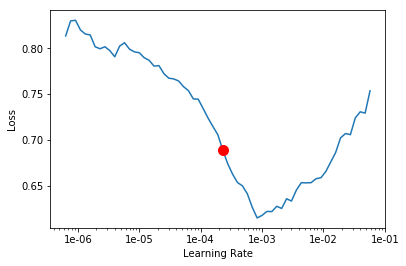

In [25]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr  if hasattr(learn, 'recorder') else 1e-2

In [26]:
from fastai.callbacks import *
learn.fit_one_cycle(5,min_grad_lr,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.302260,0.213913,0.066465,0.933535,0.929878,02:16
1,0.260727,0.123518,0.042296,0.957704,0.946626,02:16
2,0.218960,0.210241,0.092145,0.907855,0.878754,02:16
3,0.186314,0.112575,0.042296,0.957704,0.945463,02:18
4,0.139014,0.157450,0.060423,0.939577,0.924072,02:16


Better model found at epoch 0 with f1_score_a value: 0.9298778772354126.
Better model found at epoch 1 with f1_score_a value: 0.9466261267662048.


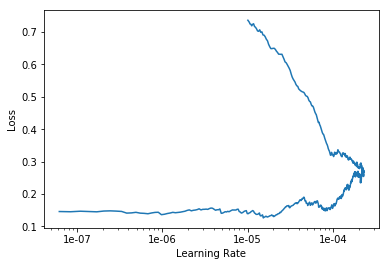

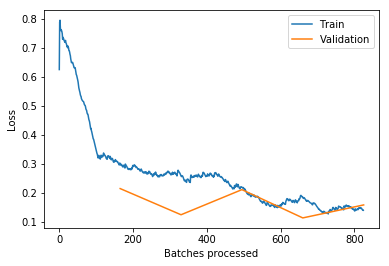

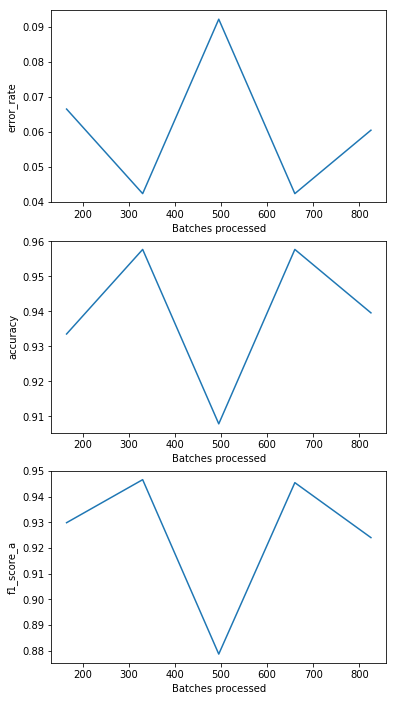

In [27]:
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 3.63E-06


/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.226644,0.117675,0.043807,0.956193,0.944457,02:16
1,0.187814,0.143046,0.060423,0.939577,0.925884,02:17
2,0.180501,0.184838,0.077039,0.922961,0.914939,02:16
3,0.181894,0.159790,0.067976,0.932024,0.925831,02:16
4,0.149689,0.116194,0.048338,0.951662,0.941734,02:17


Better model found at epoch 0 with f1_score_a value: 0.9444566369056702.


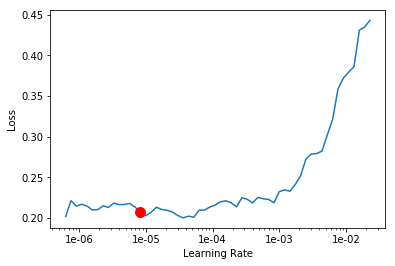

In [28]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr  if hasattr(learn, 'recorder') else 1e-2
from fastai.callbacks import *
learn.fit_one_cycle(5,min_grad_lr,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])

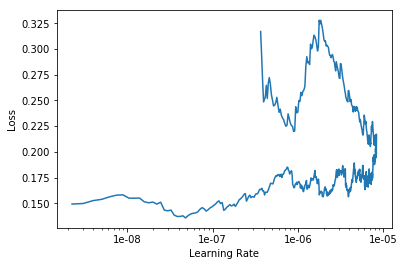

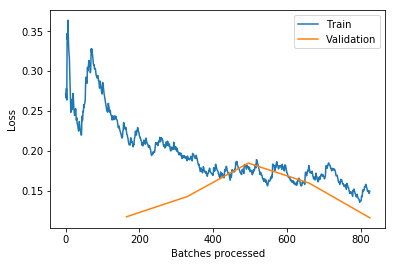

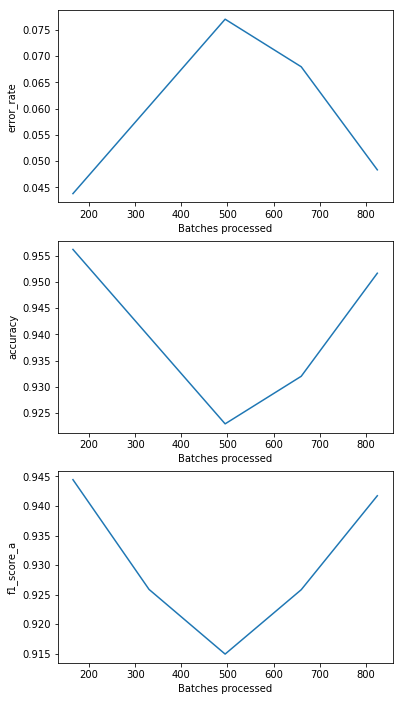

In [29]:
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [30]:
learn.load('bestmodel')

Learner(data=ImageDataBunch;

Train: LabelList (2652 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,0
Path: .;

Valid: LabelList (662 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,1,0
Path: .;

Test: None, model=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_si

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.20E-06


/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.187404,0.156666,0.067976,0.932024,0.923420,02:17
1,0.207312,0.141076,0.063444,0.936556,0.927812,02:15
2,0.199911,0.175691,0.070997,0.929003,0.912908,02:12
3,0.195768,0.136095,0.063444,0.936556,0.927531,02:12
4,0.189873,0.136767,0.063444,0.936556,0.925731,02:11


Better model found at epoch 0 with f1_score_a value: 0.9234204888343811.
Better model found at epoch 1 with f1_score_a value: 0.9278117418289185.


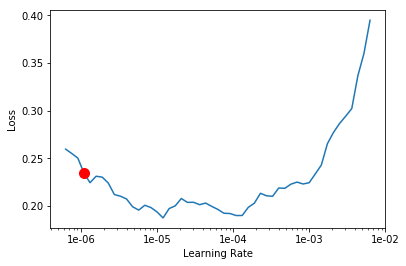

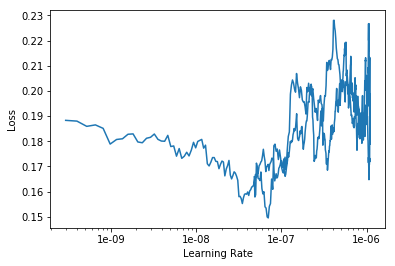

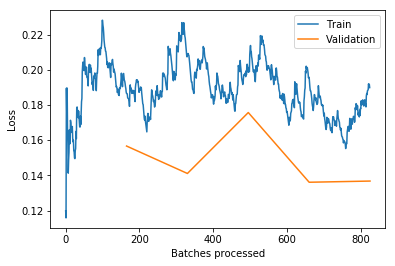

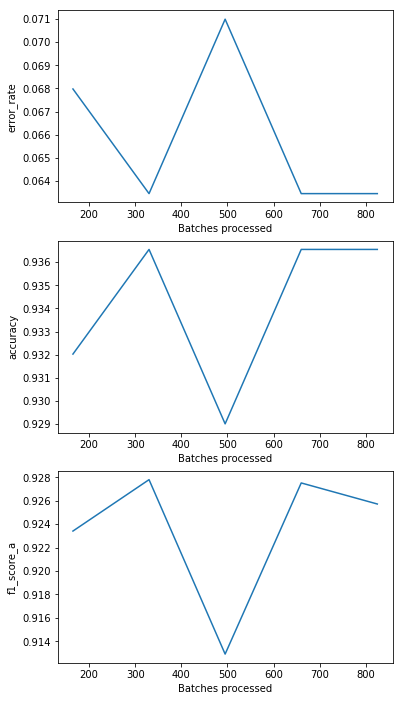

In [31]:
learn.load('bestmodel')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr  if hasattr(learn, 'recorder') else 1e-2
min_grad_lr
learn.fit_one_cycle(5,min_grad_lr,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

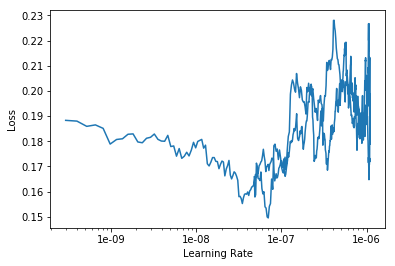

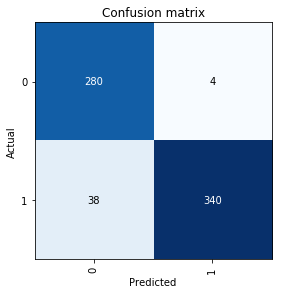

In [32]:
learn.recorder.plot()
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

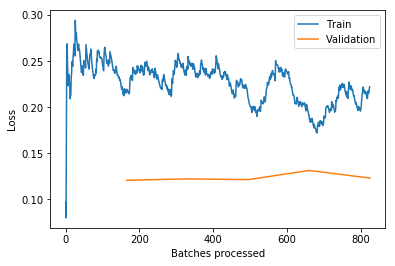

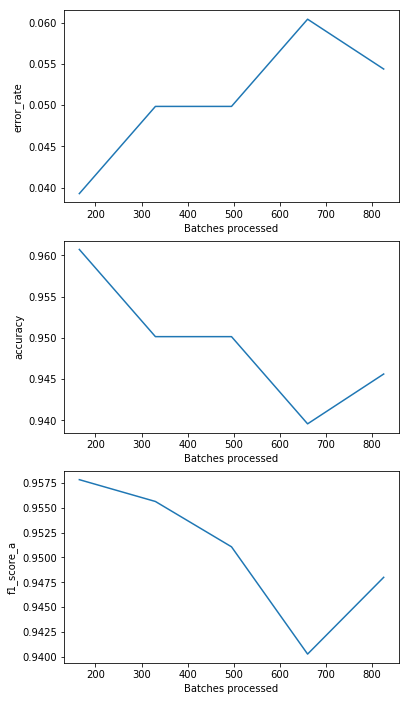

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [0]:
learn.fit_one_cycle(7,callbacks=[SaveModelCallback(learn, every='imrpovement', monitor='f1_score_a')])
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

/usr/local/lib/python3.6/dist-packages/fastai/callbacks/tracker.py:83: UserWarning: SaveModel every imrpovement is invalid, falling back to "improvement".
  warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score_a,time
0,0.342325,0.602862,0.120846,0.879154,0.873435,02:26
1,0.476754,0.269247,0.107251,0.892749,0.898704,02:22
2,0.448546,0.326775,0.154079,0.845921,0.773398,02:30
3,0.368971,0.278480,0.086103,0.913897,0.898247,02:21
4,0.339056,0.471654,0.220544,0.779456,0.801857,02:23
5,0.285377,0.236087,0.098187,0.901813,0.904666,02:23
6,0.220760,0.195197,0.081571,0.918429,0.910190,02:15


Better model found at epoch 0 with f1_score_a value: 0.8734347820281982.
Better model found at epoch 1 with f1_score_a value: 0.8987042307853699.
Better model found at epoch 5 with f1_score_a value: 0.9046664834022522.
Better model found at epoch 6 with f1_score_a value: 0.9101895093917847.


Precision of Model = 0.8994708994708994 Recall of Model  0.9883720930232558
F1 Score of Model = 0.9418282548476453


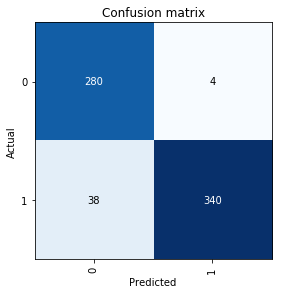

In [34]:
learn.load('bestmodel')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

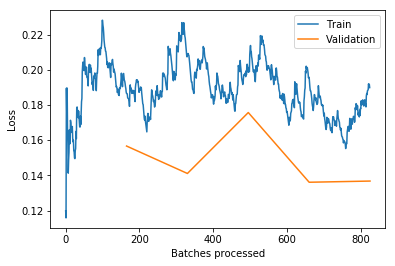

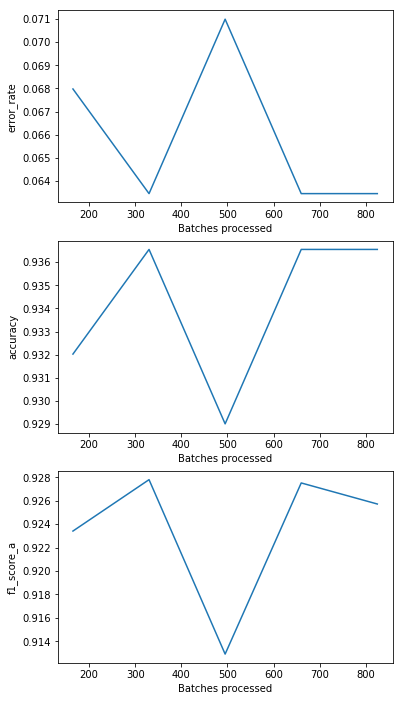

In [33]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()
